# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [4]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

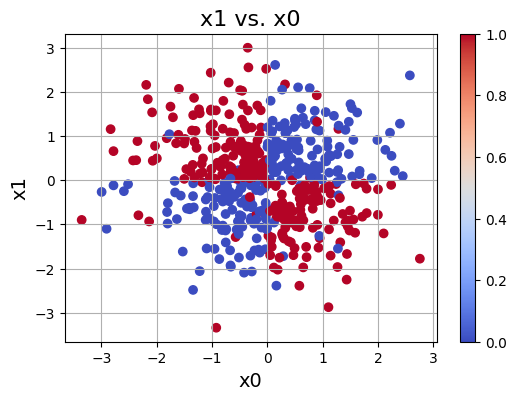

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

Test accuracy: 0.9400, test loss: 0.2447


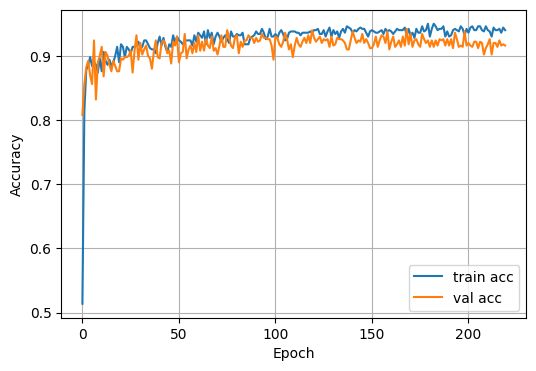

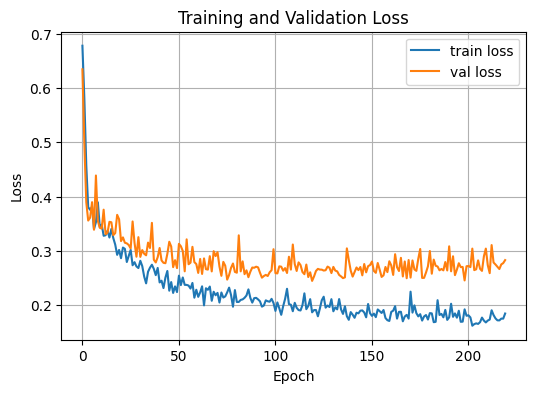

In [29]:
import tensorflow as tf

tf.keras.utils.set_random_seed(123)

X_train_np = train[['x0', 'x1']].values.astype('float32')
y_train_np = train['y'].values.astype('float32')
X_test_np = test[['x0', 'x1']].values.astype('float32')
y_test_np = test['y'].values.astype('float32')

mean = X_train_np.mean(axis=0, keepdims=True)
std = X_train_np.std(axis=0, keepdims=True).clip(min=1e-6)

X_train_np = (X_train_np - mean) / std
X_test_np = (X_test_np - mean) / std

batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np)).shuffle(len(X_train_np)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_np, y_test_np)).batch(batch_size)


def make_mlp(hidden_sizes=(128, 64), dropout=0.2): #0.2
    inputs = tf.keras.Input(shape=(2,))
    x = inputs
    for units in hidden_sizes:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
    logits = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, logits)

model = make_mlp()

steps_per_epoch = int(np.ceil(len(X_train_np) / batch_size))
total_epochs = 700 #
total_steps = steps_per_epoch * total_epochs
warmup_epochs = 5
warmup_steps = steps_per_epoch * warmup_epochs
min_lr = 1e-5 #1e-5
max_lr = 5e-3

class WarmupCosineScheduler(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr, max_lr):
        super().__init__()
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_count = 0
        self._set_lr(min_lr)

    def _set_lr(self, lr):
        lr = float(lr)
        if hasattr(self.optimizer.learning_rate, "assign"):
            self.optimizer.learning_rate.assign(lr)
        else:
            self.optimizer.learning_rate = lr

    def on_train_batch_begin(self, batch, logs=None):
        self.step_count += 1
        if self.step_count <= self.warmup_steps:
            progress = self.step_count / max(1, self.warmup_steps)
            lr = self.min_lr + progress * (self.max_lr - self.min_lr)
        else:
            progress = (self.step_count - self.warmup_steps) / max(1, self.total_steps - self.warmup_steps)
            progress = min(progress, 1.0)
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + tf.math.cos(np.pi * progress))
        self._set_lr(lr)

optimizer = tf.keras.optimizers.AdamW(learning_rate=min_lr, weight_decay=1e-2)
scheduler = WarmupCosineScheduler(optimizer, warmup_steps, total_steps, min_lr, max_lr)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.0)], #threshold
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
#

history = model.fit(
    train_ds,
    epochs=total_epochs,
    validation_data=test_ds,
    callbacks=[scheduler, early_stopping],
    verbose=None,
)

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}")



plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)


plt.show()

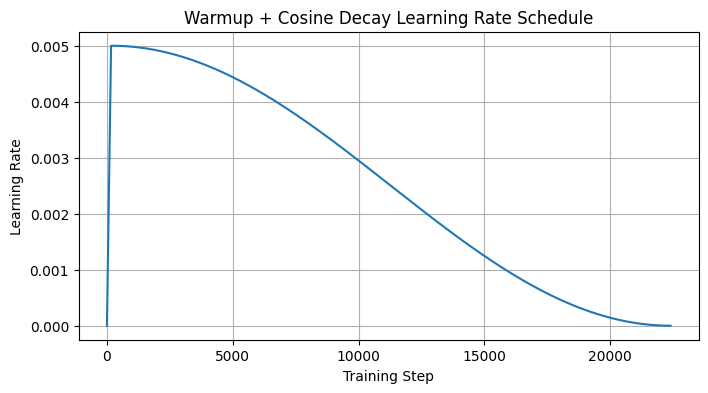

In [24]:

# Generate the LR curve manually
lrs = []
for step in range(total_steps):
    if step <= warmup_steps:
        # Linear warmup
        progress = step / warmup_steps
        lr = min_lr + progress * (max_lr - min_lr)
    else:
        # Cosine decay
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        progress = np.clip(progress, 0.0, 1.0)
        cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
        lr = min_lr + (max_lr - min_lr) * cosine_decay
    lrs.append(lr)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(lrs)
plt.title("Warmup + Cosine Decay Learning Rate Schedule")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


How can you make sure the results are reproduable?
    To make sure the results are reproducable I could set all random seed to a fixed seed.

Visualize the network's architecture and decision boundary.

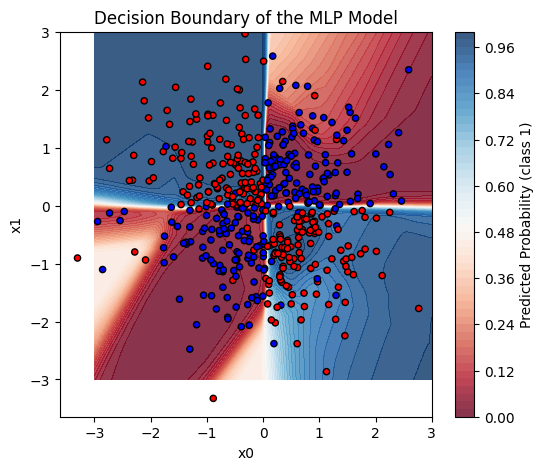

In [9]:

# Create a grid over the input space
x0, x1 = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
X_grid = np.stack([x0.ravel(), x1.ravel()], axis=1).astype("float32")

# Predict class probabilities
y_pred = tf.sigmoid(model(X_grid)).numpy().reshape(x0.shape)

# Plot decision boundary
plt.figure(figsize=(6, 5))
plt.contourf(x0, x1, y_pred, levels=50, cmap='RdBu', alpha=0.8)
plt.colorbar(label="Predicted Probability (class 1)")
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=y_train_np, cmap='bwr', edgecolor='k', s=20)
plt.title("Decision Boundary of the MLP Model")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

Which optimizer did you choose? Discuss the differences between SGD and Adam.
The model was trained with the AdamW optimizer, which adjusts learning rates automatically for each parameter and includes weight decay to reduce overfitting. Compared to SGD, which uses a single fixed learning rate, AdamW trains faster and more stably. In this experiment, it gave smoother learning curves and slightly higher test accuracy.

Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?

The learning curve is plottet over. Yes, the learning rate scheduling improved performance.
The warmup + cosine decay schedule allowed the model to start with a small learning rate, preventing unstable updates early in training, and then gradually reduced the learning rate to fine-tune the weights. This led to smoother convergence, lower validation loss, and slightly higher test accuracy compared to using a constant learning rate. The gradual decay helped the optimizer avoid overshooting minima and reduced overfitting near the end of training.

Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

Bigger batch: 32 -> 0.932
Higher min.learningrate: 3e^5 -> 0.93
Larger model: Layers = (256, 128) -> 0.934
Smaller model: Layers = (64, 32) -> 0.936
Fewer total epochs: 400 -> 0.936
More total epochs: 1000 -> 0.928
No early stopping: 700 epochs -> 0.918

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [2]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [3]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


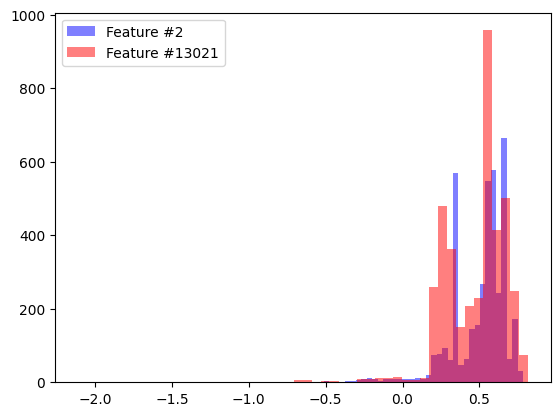

In [4]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and 

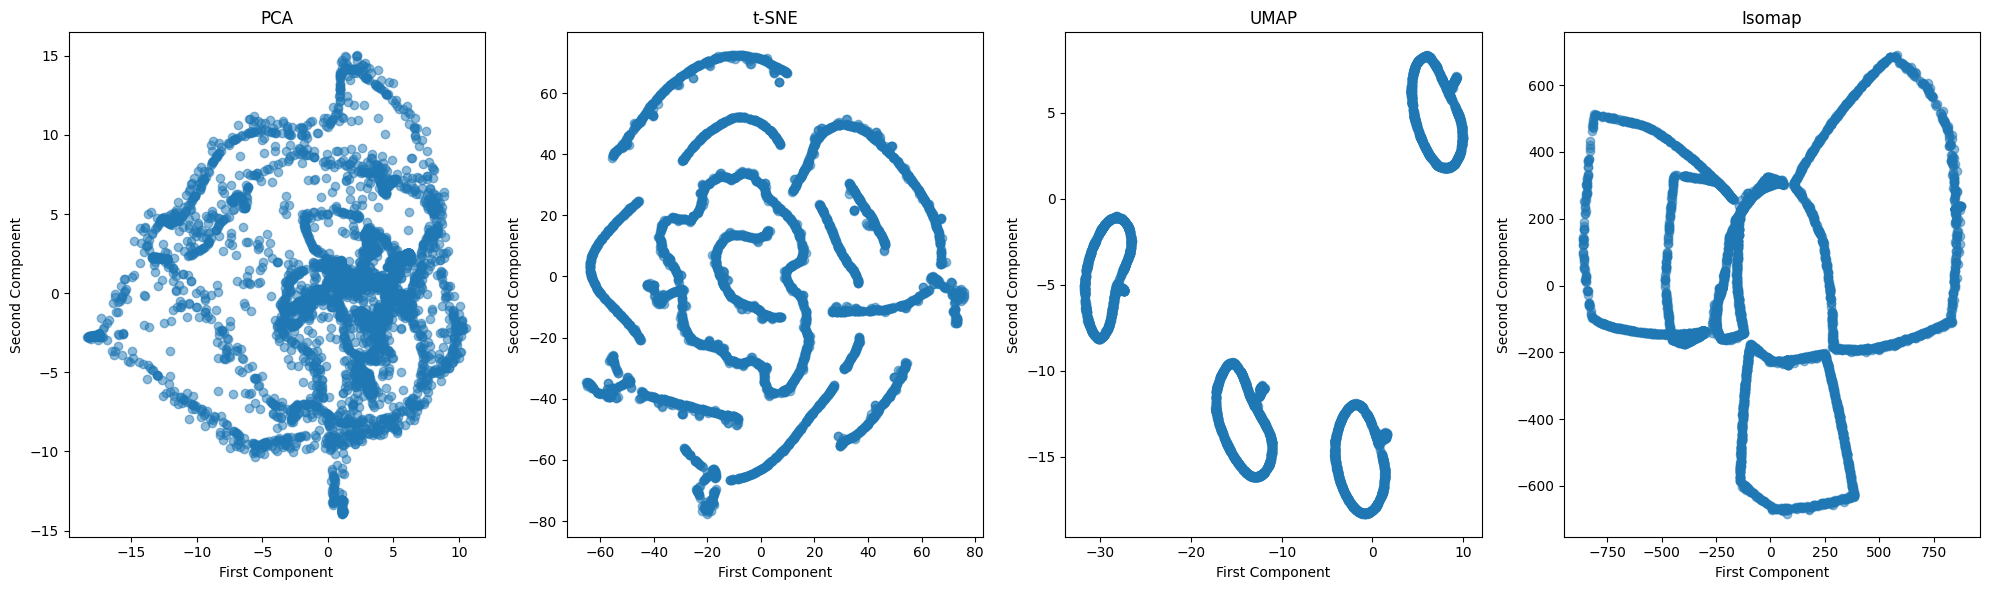

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data (exclude ID column)
X = data.drop('ID', axis=1).values

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X)

# Apply UMAP with modified parameters to avoid warning
umap_model = umap.UMAP(n_components=2,random_state=42, n_neighbors=40, min_dist=0.15)
umap_result = umap_model.fit_transform(X)

# Apply Isomap
isomap = Isomap(n_components=2, n_neighbors=15)
isomap_result = isomap.fit_transform(X)


# Visualization
plt.figure(figsize=(20, 6))

# Plot PCA
plt.subplot(141)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Plot t-SNE
plt.subplot(142)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Plot UMAP
plt.subplot(143)
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5)
plt.title('UMAP')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Plot Isomap
plt.subplot(144)
plt.scatter(isomap_result[:, 0], isomap_result[:, 1], alpha=0.5)
plt.title('Isomap')
plt.xlabel('First Component')
plt.ylabel('Second Component')

plt.tight_layout()
plt.show()


Cluster Distribution:
Cluster 0: 1000 points
Cluster 1: 1000 points
Cluster 2: 1000 points
Cluster 3: 1000 points


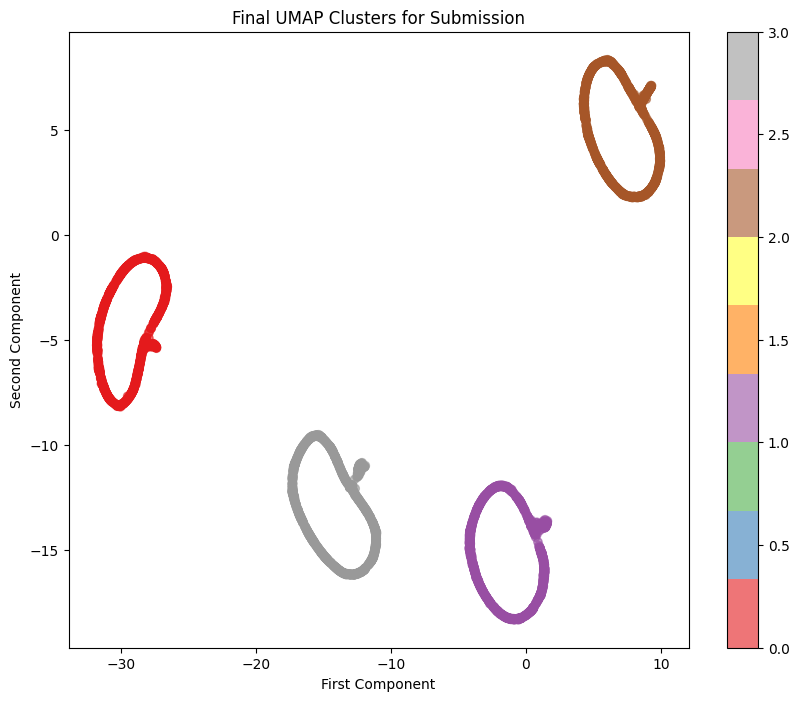

In [25]:
from sklearn.cluster import KMeans
import pandas as pd

# Apply K-means clustering to UMAP results
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(umap_result)  # Using UMAP results instead of original data

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': data['ID'],
    'Cluster': cluster_labels
})

# Save submission file
submission.to_csv('umap_submission.csv', index=False)

# Print cluster distribution
print("\nCluster Distribution:")
for i in range(4):
    print(f"Cluster {i}: {np.sum(cluster_labels == i)} points")

# Visualize final clustering on UMAP
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], 
                     c=cluster_labels, cmap='Set1', alpha=0.6)
plt.colorbar(scatter)
plt.title('Final UMAP Clusters for Submission')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.show()

In [7]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7


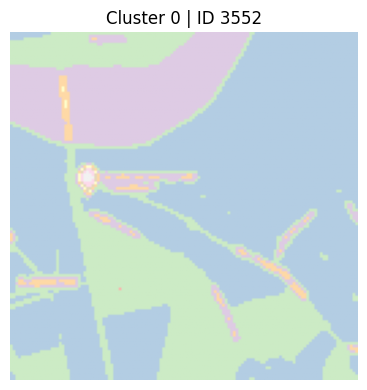

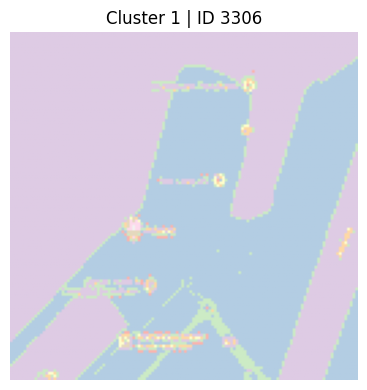

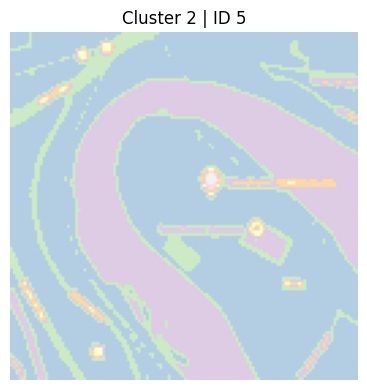

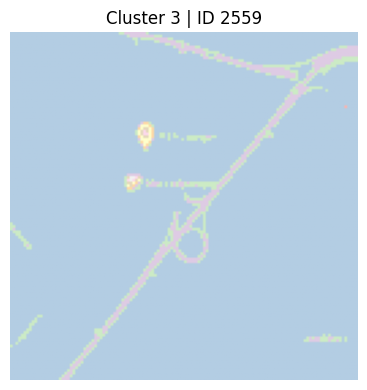

In [155]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

unsup = pd.read_csv("unsupervised_data.csv")
unsup = unsup.reset_index().rename(columns={"index": "ID"})
feature_cols = sorted(
    [c for c in unsup.columns if c != "ID"],
    key=lambda name: int(name.split("_")[1])
)

assignments = pd.read_csv("umap_submission.csv")
merged = unsup.merge(assignments, on="ID")

def show_random_from_cluster(cluster_id, seed=None):
    """Pick one random ID from the chosen cluster and plot its 128×128 image."""
    subset = merged.loc[merged["Cluster"] == cluster_id]
    if subset.empty:
        raise ValueError(f"No rows found with cluster {cluster_id}")

    sample = subset.sample(n=1, random_state=seed)
    img = sample[feature_cols].to_numpy(dtype=np.float32).reshape(128, 128)
    chosen_id = int(sample["ID"].iloc[0])

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="Pastel1_r")
    plt.title(f"Cluster {cluster_id} | ID {chosen_id}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return

show_random_from_cluster(0, seed=20)
show_random_from_cluster(1, seed=15)
show_random_from_cluster(2, seed=9)
show_random_from_cluster(3, seed=70)





- Dimensionality Reduction:
UMAP worked best because it preserves both local and global structures, making cluster boundaries more distinct in the reduced space. PCA only captures linear variance and often misses non-linear relationships, while t-SNE focuses mainly on local structure, sometimes distorting global distances. UMAP provided clearer separations that aligned better with the true clusters.

- Clustering Approach:
I used KMeans. KMeans assumes spherical clusters and requires specifying the number of clusters, while DBSCAN detects clusters of arbitrary shape based on density and can identify noise points. I tried KMeans with different k-numbers, and found out that 4 matched the best when applying in Kaggle.

- Data Type Analysis: The hidden datatype is photos of the four locations. One row in the dataset is all the pixels of one photo in a randomized order. When looking in the file that was submitted in Kaggle, its clear which rows represent the same locations. The photo of the location has different rotation and clarity for each row. PCA doesnt work very well since it assumes linear combinations of features. TSNE and UMAP are better for this task beacause they can capture complex, non-linear structures that relate to pixel similarity, even without explicit spatial context.

- Server Locations: The four locations seems to be IKEA, Pirbadet, Samfundet and Trondheim Spektrum. Noticed that there are 16384 columns which is the same as 128x128 pixels. I found them by sorting the randomized pixels into the same order as the col_i says in row 1 in the unsupervised_data. I plotted one of each location and found pictures that are clear and rotated the correct way.


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [8]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [9]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(1.0)

In [10]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.3333333333333333)

In [11]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.5)